# <실험내용>
## 수천명의 환자의 x-ray 영상을 normal/penumonia로 분류하는 것입니다.

## 1. 데이터셋을 읽어옵니다

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import os,shutil
#jpg이미지를 넣은 폴더에 자동으로 cats_and_dogs_small 폴더를 생성한다.
base_dir = '/gdrive/My Drive/chest_xray'



#생성된 cats_and_dogs_small 폴더에 train, validation, test 폴더가 하위 폴더로 생상된다.
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonias_dir = os.path.join(validation_dir, 'PNEUMONIA')

test_norma_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonias_dir = os.path.join(test_dir, 'PNEUMONIA')

Using TensorFlow backend.


## 2. normal/penumnonia를 분류하기위한 resnet 모델을 사용합니다

In [0]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

num_classes = 2


model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

## 3.과적합 및 학습 성능을 올리기 위해 데이터 augmentation을 해줍니다

In [0]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )

train_generator = data_generator_with_aug.flow_from_directory(
       directory = '/gdrive/My Drive/chest_xray/train/',
       target_size = (256, 256),
       batch_size = 10,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = '/gdrive/My Drive/chest_xray/val/',
       target_size = (256, 256),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = '/gdrive/My Drive/chest_xray/test/',
       target_size = (256, 256),
       batch_size = 1,
       class_mode = 'categorical')

history=model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = 15,
       steps_per_epoch=200,
       validation_data=validation_generator) # specify where model gets validation data


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
200/200 [==============================] - 67s 336ms/step - loss: 0.1760 - acc: 0.9315 - val_loss: 1.0003 - val_acc: 0.5625
Epoch 2/15
200/200 [==============================] - 64s 319ms/step - loss: 0.1666 - acc: 0.9340 - val_loss: 0.1535 - val_acc: 0.9375
Epoch 3/15
200/200 [==============================] - 64s 318ms/step - loss: 0.1585 - acc: 0.9390 - val_loss: 0.1947 - val_acc: 1.0000
Epoch 4/15
200/200 [==============================] - 64s 320ms/step - loss: 0.1364 - acc: 0.9485 - val_loss: 0.1907 - val_acc: 1.0000
Epoch 5/15
200/200 [==============================] - 64s 322ms/step - loss: 0.1556 - acc: 0.9405 - val_loss: 0.1829 - val_acc: 0.9375
Epoch 6/15
200/200 [==============================] - 65s 325ms/step - loss: 0.1338 - acc: 0.9495 - val_loss: 0.1641 - val_acc: 0.9375
Epoch 7/15
200/200 [==============================] - 64s 321ms/ste

## 4.학습 결과를 곡선으로 나타내줍니다.

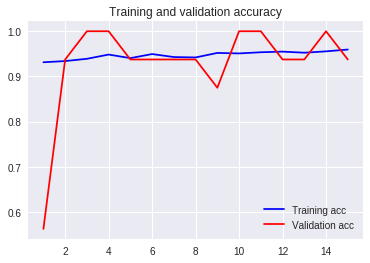

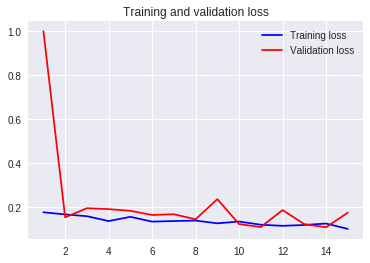

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 5.testset에서도 모델이 잘 작동하는지 확인해줍니다

In [0]:
from tensorflow.python.keras.models import Sequential
from keras.models import load_model

print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 100)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
acc: 84.00%


## 6. testset을 normal/pneumonia로  예측 해줍니다.

In [0]:
# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(test_generator)

y_pred = np.argmax(output, axis=1)




-- Predict --


In [0]:
len(test_generator.classes)

624

## 7.예측한 testset을 roc곡선으로 나타내줍니다.

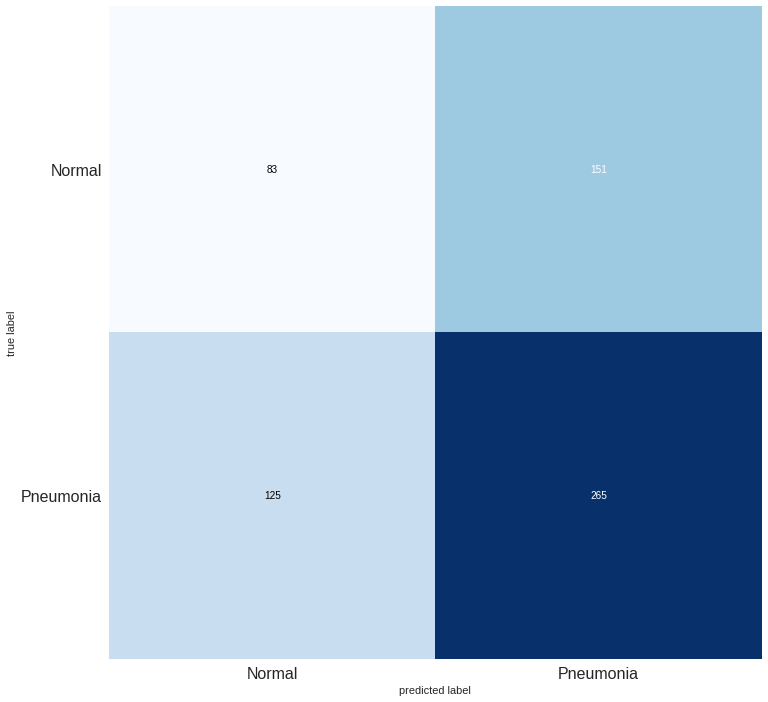

In [0]:

import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

# Get the confusion matrix

CM = confusion_matrix(test_generator.classes, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 12))
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

